In [ ]:
import sklearn 
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import json
import cv2 as cv
import pandas as pd

# for SVM 
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.decomposition import PCA

# dlib detector 
import dlib
from google.colab.patches import cv2_imshow

## Experiments 

In [ ]:
# haar cascade mouth classifier 

path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img/1001.jpg'
mouth_classifier = cv.CascadeClassifier('haarcascade_mcs_mouth.xml')
img = cv.imread(path)
gray_image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
face_detect = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# detect faces
detected_faces = face_detect(gray_image)

face_area = {}
mouth_area = {}

for rect in detected_faces:

  column = rect.left()
  row = rect.top()
  width  = rect.right() - column
  height = rect.bottom() - row
  area_f = width * height
  face_area[area_f] = (column, row, width, height)

max_area_f = max(face_area.keys())
x, y, w, h = face_area[max_area_f]
resized_image = gray_image[y: y+ h, x:x + w]
detected_mouth = mouth_classifier.detectMultiScale(resized_image)

for (x,y,w,h) in detected_mouth:
  area_f = w * h
  mouth_area[area_f] = (x, y, w, h)

max_area_m = max(mouth_area.keys()) 

x, y, w, h = mouth_area[max_area_m]

mouth_image = resized_image[y:y+h, x:x+w]

cv2_imshow(mouth_image)

In [ ]:
# shape detector trial

path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img/1159.jpg'
mouth_classifier = cv.CascadeClassifier('haarcascade_mcs_mouth.xml')
img = cv.imread(path)
gray_image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
face_detect = dlib.get_frontal_face_detector()
os.chdir('/content/drive/MyDrive/UCL_machine_learning_course ')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# detect faces
detected_faces = face_detect(gray_image)

face_area = {}
mouth_area = {}

for rect in detected_faces:

  column = rect.left()
  row = rect.top()
  width  = rect.right() - column
  height = rect.bottom() - row
  face_area[width*height] = rect
  

max_area = max(face_area.keys())
rect_1 = face_area[max_area]
shape = predictor(gray_image, rect_1)

cord_array = np.zeros((shape.num_parts, 2), dtype = 'int')

for i in range(0, shape.num_parts):
  cord_array[i] = (shape.part(i).x, shape.part(i).y)

face_shapes = np.reshape(cord_array, [136])
tr_shapes = np.transpose(face_shapes)/max(face_shapes)

## data processing 

In [ ]:

def image_process(input_path, output_path, counter):

  img = cv.imread(input_path)
  gray_image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  face_detect = dlib.get_frontal_face_detector()
  os.chdir('/content/drive/MyDrive/UCL_machine_learning_course ')
  predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
  detected_faces = face_detect(gray_image)

  if len(detected_faces) == 0:
    print('No faces were found in image_number {}'.format(counter))
    return False
  else:
    face_area = {}
    mouth_area = {}
    for rect in detected_faces:
      column = rect.left()
      row = rect.top()
      width  = rect.right() - column
      height = rect.bottom() - row
      face_area[width*height] = rect

    max_area = max(face_area.keys())
    rect_1 = face_area[max_area]
    shape = predictor(gray_image, rect_1)
    cord_array = np.zeros((shape.num_parts, 2), dtype = 'int')
    for i in range(0, shape.num_parts):
      cord_array[i] = (shape.part(i).x, shape.part[(i).y)

    face_shapes = np.reshape(cord_array, [136])
    tr_shapes = [np.transpose(face_shapes)/max(face_shapes)]

    with open(output_path, "a") as fp:
      np.savetxt(fp, tr_shapes,  fmt="%1.3f", delimiter=",")

    return True


def process_data_2(base_file, output_dir, labels_in, labels_out , sample_size):

  list_ims = sorted(os.listdir(base_file))

  for counter, img in enumerate(list_ims):
    if counter > sample_size:
      print('Reached the end of the sample size')
      break
    else:
      print('processing image number {} with name {}'.format(counter, img))
      input_path = os.path.join(base_file, img)
      output_path = output_dir
      result = image_process(input_path, output_path, counter)
      if result:
        with open(labels_in, 'r') as d:
          with open(labels_out, 'a') as f:
            lines = d.readlines()[1:]
            for line in lines:
              file_name = line.split('/')[0].split()[1]
              if file_name == img:
                f.write(line)
              else:
                continue

def get_data(feature_path, labels_path):

  points_list = []

  with open(feature_path, 'r') as d:
    lines = d.readlines()[:1927]
    for i in lines:
      e = list(eval(i))
      points_list.append(e)

    X_out = np.asarray(points_list)

  columns = ['Image number', 'file name', 'Gender', 'smiling']
  y_data = pd.read_csv(labels_path, delimiter = '\t', header = None, names = columns)
  y_out_m = np.asarray(y_data['smiling'])


  x_train, x_test, y_train, y_test = train_test_split(X_out, y_out_m, test_size = 0.3, shuffle = True)

  return x_train, x_test, y_train, y_test

def get_validation_set(x_train, y_train):

  x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size = 0.3, shuffle = 0.3)

  return x_train_1, x_val, y_train_1, y_val


In [ ]:
base = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img'
out =  '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeba.csv'
labels_in = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/labels.csv'
labels_out = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeb_labels.csv'
process_data_2(base, out, labels_in, labels_out, 2000)

## Experimients

In [ ]:
labels_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeb_labels.csv'
points_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeba.csv'

points_list = []
tr_shapes = [[0.4,0.5, 0.6,0.45,0.055]]
with open(points_path, 'r') as d:
  lines = d.readlines()
  for i in lines[:1927]:
    e = list(eval(i))
    print(e)
    break
    
 

## Hyper parameter optimization

In [ ]:
labels_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeb_labels.csv'
points_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/A2 datasets/celeba.csv'

# trianing on defualt SVC
x_train, x_test, y_train, y_test = get_data(points_path, labels_path)
x_train_1, x_val, y_train_1, y_val = get_validation_set(x_train, y_train)
model = SVC()
model.fit(x_train_1, y_train_1)

SVC()

In [ ]:
with open(points_path, 'r') as d:
  lines = d.readlines()
  print(len(lines))

with open(labels_path, 'r') as l:
  lines = l.readlines()
  print(len(lines))

1937
1927


In [ ]:
param_grid = {'C': [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']} 

grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, scoring = 'accuracy')

# fitting the model for grid search
grid.fit(x_val, y_val)
allscores= grid.cv_results_['mean_test_score']
print(allscores)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.519 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.506 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.506 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.506 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.506 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.716 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.790 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.840 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.778 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.889 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly

In [ ]:
print(grid.best_params_)

{'C': 0.4, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
param_grid_2 = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]}
model_1 = SVC(kernel = 'poly', gamma = 'scale')
grid_2 = GridSearchCV(model_1, param_grid_2, refit = True, verbose = 3, scoring = 'accuracy')
grid_2.fit(x_val, y_val)
allscores= grid_2.cv_results_['mean_test_score']
print(allscores)

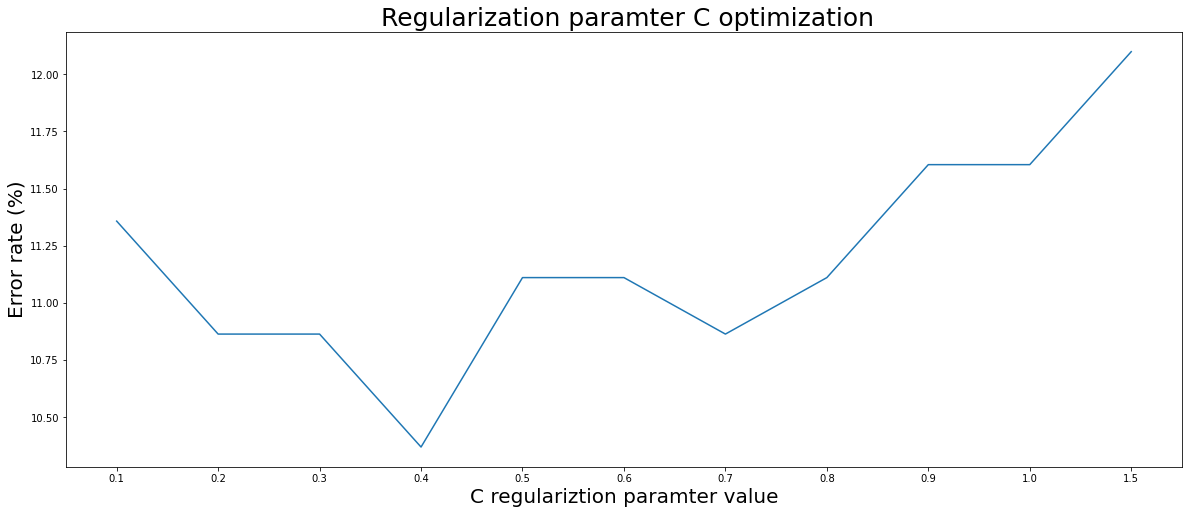

In [ ]:
C_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]
error_rates = [ (1-i)*100 for i in allscores]
plt.figure(figsize = (20,8))
plt.title(' Regularization paramter C optimization', fontsize = 25)
plt.xlabel('C regulariztion paramter value', fontsize = 20)
plt.ylabel('Error rate (%)', fontsize = 20)
plt.xticks(np.arange(11),C_params)
plt.plot(error_rates)

In [ ]:
model_1.fit(x_train, y_train)
y_pred_train = model_1.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          -1       0.89      0.91      0.90       669
           1       0.91      0.89      0.90       679

    accuracy                           0.90      1348
   macro avg       0.90      0.90      0.90      1348
weighted avg       0.90      0.90      0.90      1348



In [ ]:
# testing dataset accuracy

y_pred_test = model_1.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.86      0.91      0.88       314
           1       0.88      0.83      0.85       265

    accuracy                           0.87       579
   macro avg       0.87      0.87      0.87       579
weighted avg       0.87      0.87      0.87       579



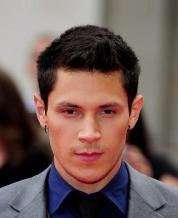

In [ ]:
os.chdir('/content/drive/MyDrive/UCL_machine_learning_course ')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
face_detect = dlib.get_frontal_face_detector()
path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/celeba/img/1200.jpg'
image = cv.imread(path)
gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
detected_faces = face_detect(gray_image)

# for rect in detected_faces:

#   column = rect.left()
#   row = rect.top()
#   width  = rect.right() - column
#   height = rect.bottom() - row
  
#   shape = predictor(gray_image, rect)

#   for n in range(0, 68):
#     x = shape.part(n).x
#     y = shape.part(n).y
#     cv.circle(image, (x, y), 2, (255, 0, 0), -1)

cv2_imshow(image)